In [100]:
import glob, os, re, json, pickle
import pandas as pd
from classifier import *
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
%reload_ext autoreload
%autoreload 2

In [16]:
df_human = pd.read_json('human_labeled_data.json')
df_human['text'] = df_human['text_data'].str.replace('https[^\s]*\s', '')
df_human

,text_id,text_data,labeled,selected,taught,labels,users,major_label,uncertainty,predicted_label,text
0,373,https://twitter.com/Gert_Woellmann/status/1216...,False,False,True,[506 education +],[marvin.mueller@posteo.de],506 education +,1.000000,506 education +,Weltbeste Bildung! Jetzt! Weltbeste Bildung! J...
1,752,https://twitter.com/tarogermany1/status/123819...,False,False,True,[501 environmentalism +],[marvin.mueller@posteo.de],501 environmentalism +,0.686072,501 environmentalism +,"(2/2) Das TH in das sie gebracht wurde, ist kn..."
2,313,https://twitter.com/lcoygermany/status/1259085...,False,False,True,[501 environmentalism +],[marvin.mueller@posteo.de],501 environmentalism +,0.966821,501 environmentalism +,„Heute gekaufte Autos produzieren über 15 Jahr...
3,323,https://twitter.com/peppermint_v/status/125562...,False,False,True,[202 democracy +],[marvin.mueller@posteo.de],202 democracy +,0.999661,202 democracy +,Wir brauchen eine Opposition. Das macht eine D...
4,474,https://twitter.com/SPDEuropa/status/121483242...,False,False,True,[202 democracy +],[marvin.mueller@posteo.de],202 democracy +,0.999614,202 democracy +,Rechtsstaat und Demokratie in Europa schützen!...
...,...,...,...,...,...,...,...,...,...,...,...
893,42,https://twitter.com/BoardGameGreek/status/1221...,False,False,True,[ignored],[marvin.mueller@posteo.de],ignored,0.939333,ignored,Der Kampf der Nationen mit @glucksschinder – a...
894,964,https://twitter.com/uniklinik_hd/status/122208...,False,False,True,[ignored],[marvin.mueller@posteo.de],ignored,0.917466,ignored,#op 4.1 Anschlussveranstaltung mit @Hohenfelln...
895,421,https://twitter.com/JochumPeter/status/1225162...,False,False,True,[202 democracy +],[marvin.mueller@posteo.de],202 democracy +,0.999634,202 democracy +,Eben. Deshalb braucht es nicht noch ein Schulf...
896,672,https://twitter.com/LuiseMiklis/status/1235830...,False,False,True,[503 social justice +],[marvin.mueller@posteo.de],503 social justice +,0.990995,503 social justice +,Einen wundervollen Weltfrauentag an all die un...


# Classifier trained on manifesto,  tested on tweets

In [17]:
dd = score_texts(df_human)
print(classification_report(dd['major_label'].str.replace('\d\d\d ',''),dd['manifestolabel']))

                        precision    recall  f1-score   support

                             0.00      0.00      0.00         0
         agriculture +       0.67      0.67      0.67        12
 anti-growth economy +       0.00      0.00      0.00        15
          centralism +       0.00      0.00      0.00         1
        constitution +       0.00      0.00      0.00         1
        constitution -       0.00      0.00      0.00         1
  controlled economy +       0.00      0.00      0.00         1
             culture +       0.62      0.94      0.75        16
        decentralism +       0.00      0.00      0.00         0
           democracy +       0.87      0.70      0.78       108
        economic goals       0.00      0.00      0.00         1
           education +       0.49      0.81      0.61        37
           education -       0.00      0.00      0.00         2
    environmentalism +       0.59      0.88      0.71       144
              europe +       0.74      

/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Train on manifestos and tweets, test on 20% held out tweets

In [18]:
df_manifesto = get_manifesto_data()
tweets_train, tweets_test, labels_train,  labels_test = train_test_split(df_human['text'], 
                                                                         df_human['major_label'].str.replace('\d\d\d ',''),
                                                                        test_size=.2)
train_text = pd.concat([df_manifesto['text'],tweets_train])
train_labels = pd.concat([df_manifesto['manifestolabel'],labels_train]) 
train_single(train_text, train_labels, 'tweets')

df_test = pd.concat([tweets_test,labels_test],axis=1)
df_test.columns = ['text','manifestolabel_true']
tw = score_texts(df_test,['tweets'])
print(classification_report(tw['manifestolabel_true'],tw['tweets']))

Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.5s finished
/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

                             0.00      0.00      0.00         0
         agriculture +       0.50      0.67      0.57         3
 anti-growth economy +       0.00      0.00      0.00         4
             culture +       0.00      0.00      0.00         0
           democracy +       0.93      0.65      0.76        20
           education +       0.67      0.67      0.67         6
    environmentalism +       0.77      0.92      0.84        25
              europe +       0.86      0.75      0.80         8
     free enterprise +       0.00      0.00      0.00         3
freedom/human rights +       0.67      0.80      0.73        10
               ignored       1.00      0.06      0.12        31
      infrastructure +       0.75      0.38      0.50         8
    internationalism +       0.00      0.00      0.00         1
              labour +       1.00      1.00      1.00         3
       law and order +       0.50      

/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
train_text = pd.concat([df_manifesto['text'],df_human['text']])
train_labels = pd.concat([df_manifesto['manifestolabel'],df_human['major_label'].str.replace('\d\d\d ','')]) 
train_single(train_text, train_labels, 'all_tweets')

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.5s finished
/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
# read all tweets and remove those that were labeled
df = pd.read_pickle('all_tweets.pickle')#.drop_duplicates('id')
df['text'] = df['text'].fillna('')
df = df[df.text.isin(df_human['text']) == False]
# (df.loc[df['after'],'manifestolabel_keywords'].value_counts() / df.loc[df['before'],'manifestolabel_keywords'].value_counts()).sort_values()

democracy +               0.812749
incentives +              0.863506
economic planning +       0.908220
political authority +     0.932638
education +               0.968456
foreign special -         0.981094
infrastructure +          1.009323
internationalism -        1.026153
national way of life -    1.036525
social justice +          1.063369
traditional morality +    1.075683
europe +                  1.075869
culture +                 1.083113
constitution +            1.088556
protectionism +           1.108600
social harmony +          1.152259
constitution -            1.159521
political corruption -    1.176829
non economic groups +     1.208969
military -                1.221111
national way of life +    1.223430
labour +                  1.234493
multiculturalism +        1.250000
marxist analysis +        1.267455
productivity +            1.272016
market regulation +       1.277793
multiculturalism -        1.309286
gov-admin efficiency +    1.312319
internationalism +  

In [38]:
df_scored = score_texts(df, label_types=['all_tweets'], min_precision=.3)
df_scored.to_pickle('scored_tweets_all_tweets.pickle')

In [76]:
df_scored = pd.read_pickle('scored_tweets_all_tweets.pickle')
# len(df_scored.drop_duplicates('id'))

In [77]:
df_scored['manifestolabel'] = df_scored['all_tweets']
low_precision = df_scored['all_tweets'] == ''
ignored = df_scored['all_tweets'] == 'ignored'
df_scored = df_scored[~low_precision & ~ignored]
df_scored

,username,to,text,retweets,favorites,replies,id,permalink,author_id,formatted_date,...,geo,urls,url_text,manifestolabel_keywords,date,before,after,all_tweets_proba,all_tweets,manifestolabel
18,mariamhofholz,None,"Ich haette gerne eine Regierung, die stolz investiert und sich um Effizienz kümmert. #gesundheitundpflege, #FuE, #klima, #Infrastruktur. #zib2 #kurz",0.0,0.0,0.0,1222993704396501012,https://twitter.com/mariamhofholz/status/1222993704396501012,2.705789e+08,Thu Jan 30 21:23:15 +0000 2020,...,,,,internationalism -,2020-01-30 21:23:15,True,False,0.373396,infrastructure +,infrastructure +
20,HartwigKmmerle,wiase,"Logisch, den politischen Gegener mit allen Mitteln bekämpfen. Das ist die berühmte Demokratie ohne Volk, von der ständig die Rede ist.",0.0,0.0,0.0,1222989785138180110,https://twitter.com/HartwigKmmerle/status/1222989785138180110,9.607460e+08,Thu Jan 30 21:07:41 +0000 2020,...,,,,internationalism -,2020-01-30 21:07:41,True,False,0.672917,democracy +,democracy +
42,endstoff,None,Das mit China ist doch alles Karma Guck Mal was die ganzen Idioten gemacht haben das ist die Strafe dafür,0.0,2.0,0.0,1222973381181628417,https://twitter.com/endstoff/status/1222973381181628417,8.207570e+17,Thu Jan 30 20:02:30 +0000 2020,...,,,,internationalism -,2020-01-30 20:02:30,True,False,0.312171,political authority +,political authority +
54,FraktionGruenBW,FraktionGruenBW,"Wir baden im Land aus, was die GroKo im Bund verbockt hat: Es gab vollmundige Ankündigungen der SPD, was an Seehofers Gesetzentwurf alles geändert werden würde – nichts davon ist passiert, nichts davon haben Sie eingehalten!",0.0,0.0,1.0,1222960194512203776,https://twitter.com/FraktionGruenBW/status/1222960194512203776,4.257208e+08,Thu Jan 30 19:10:06 +0000 2020,...,,,,internationalism -,2020-01-30 19:10:06,True,False,0.511246,political authority +,political authority +
80,PippoBavarese,Fabian_Reetz,Danke. Darauf kommen wir gerne zurück. Die #BAGenergie von @Die_Gruenen hat dazu bereits einen 1. Entwurf für ein sektorübergreifendes Energiemarktdesign vorgelegt &amp; diskutiert den gerade mit unserer @GrueneBundestag Fraktion+Partei. Aber wir schärfen natürlich laufend nach,0.0,1.0,0.0,1222941907707408384,https://twitter.com/PippoBavarese/status/1222941907707408384,1.723330e+07,Thu Jan 30 17:57:26 +0000 2020,...,,,,internationalism -,2020-01-30 17:57:26,True,False,0.311934,political authority +,political authority +
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267617,Bundesbox,NaN,Habt ihr es nicht ertragen euer skelett in Norte dam das falsche Spiel was wir mit euch tun werden oder seit ihr immer noch intelligent weil eure Programm BRD ist note dam was ihr mal getan habt und somit Mörder wenn man euch knackt.. Thor Adam,0.0,0.0,0.0,1.24681e+18,https://twitter.com/Bundesbox/status/1246811480986705923,2.967724e+08,Sun Apr 05 14:46:36 +0000 2020,...,NaN,NaN,NaN,economic planning +,2020-04-05 14:46:36,False,True,0.302956,political authority +,political authority +
267623,KimCM,DrIngEndres,Fechinger Verhältnisse in Dudweiler. Bei Saarbrücker Problemviertel scheint eine Ost-West-Verschiebung stattzufinden.,0.0,0.0,0.0,1.24681e+18,https://twitter.com/KimCM/status/1246806070250651649,2.978570e+08,Sun Apr 05 14:25:06 +0000 2020,...,NaN,https://twitter.com/DrIngEndres/status/1246799010691723264,"In deinem Browser ist JavaScript deaktiviert. Möchtest du mit dem klassischen Twitter weitermachen? Ja \n Dies ist eine veraltete Version von twitter.com, die am 1. Juni 2020 eingestellt wird. Stelle bitte auf einen unterstützten Browser um oder deaktiviere die Erweiterung, die deinen Browser maskiert. Eine Liste der unterstützten Browser findest du in unserem Hilfe-Center.\n Nerd, Husband, Parent, Feminist, Asimov Collector, Code Monkey, and http://drsecurity.de on screen and in real life.\nBorn at 328 ppm. \n Du kannst deine Tweets vom Web aus und über Drittapplikationen mit einem Standort versehen, wie z.B. deiner Stadt oder deinem genau

In [78]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)
above_precision_idx = df_scored['manifestolabel'] != ''
above_length_idx = df_scored['text'].apply(len) > 50
interacted_with = (df_scored['favorites'] > 10) | \
                    (df_scored['replies'] > 10) | \
                    (df_scored['retweets'] > 10)
valid = above_length_idx & above_precision_idx & interacted_with
df_scored.loc[valid,:].head(n=20)

<ipython-input-78-9967ece9758d>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,username,to,text,retweets,favorites,replies,id,permalink,author_id,formatted_date,...,geo,urls,url_text,manifestolabel_keywords,date,before,after,all_tweets_proba,all_tweets,manifestolabel
154,the_aeschli,None,Klima Umweltschutz Rechtsrutsch Korruption Hass und Hetze Bildung Armut Gesundheitskosten Krieg und Terror Und dann eines Morgens in der Schweiz: Fondue-Emoji,1.0,16.0,1.0,1222859159432986626,https://twitter.com/the_aeschli/status/1222859159432986626,4.293346e+08,Thu Jan 30 12:28:37 +0000 2020,...,,,,internationalism -,2020-01-30 12:28:37,True,False,0.316939,environmentalism +,environmentalism +
316,HMWK_Hessen,None,"Mit dem Haushalt 2020 stärken wir die Bedeutung von Wissenschaft und Kultur Ministerin @Angela_Dorn hat heute in ihrer Rede im @Landtag_Hessen betont, dass Wissenschaft und Kultur in bewegten Zeiten Leitlinien setzen und Denkanstöße bieten können.",5.0,19.0,0.0,1222582125758754819,https://twitter.com/HMWK_Hessen/status/1222582125758754819,1.105414e+18,Wed Jan 29 18:07:47 +0000 2020,...,,,,internationalism -,2020-01-29 18:07:47,True,False,0.324228,culture +,culture +
1503,FabianGramling,None,"Viele wollen mehr Frauen an der Spitze! Wir haben die richtige Spitzenkandidatin mit Susanne Eisenmann - mit Mut und Entschlossenheit die richtigen Entscheidungen treffen. Für uns, für ein starkes Baden-Württemberg! #Schöntal20 #cdu #ltw21 @CDU_BW @CDU_FraktionBW",2.0,12.0,0.0,1221001255071506432,https://twitter.com/FabianGramling/status/1221001255071506432,7.383583e+17,Sat Jan 25 09:25:58 +0000 2020,...,,,,internationalism -,2020-01-25 09:25:58,True,False,0.384000,political authority +,political authority +
2105,AutorToto,None,"„Dies ist eine Welt, in der Kraftmeier in Ländern wie #China und #Russland massiv aufrüsten, und #Europa sitzt herum und redet über Green Deals. Ich würde sagen: Hallo? Aufwachen!“ Niall #Ferguson https://www.welt.de/wirtschaft/plus205258763/Niall-Ferguson-Merkels-Kanzlerschaft-war-ein-kolossaler-Ausfall.html?wtmc=socialmedia.twitter.shared.web via @welt",33.0,79.0,11.0,1220133424951889922,https://twitter.com/AutorToto/status/1220133424951889922,1.613534e+08,Wed Jan 22 23:57:32 +0000 2020,...,,https://www.welt.de/wirtschaft/plus205258763/Niall-Ferguson-Merkels-Kanzlerschaft-war-ein-kolossaler-Ausfall.html?wtmc=socialmedia.twitter.shared.web,"„Ihr Deutschen halt“: Gar nicht richtig hätten die WELT-Reporter mit ihren Berichten und Tweets über den Auftritt von Donald Trump gelegen, sagt Niall Ferguson bei einem kurzen Zusammentreffen auf den Fluren des Kongresszentrums in Davos, feixend, aber nur halb im Scherz. Grund genug für die Verabredung zu einem ausführlicheren Interview am Rande des Weltwirtschaftsforums. Ferguson, der in Havard und an der Stanford University in Kalifornien lehrte, ist gebürtiger Schotte. Doch er hat sich, sagt er, vor nicht allzulanger Zeit, zusätzlich die amerikanische Staatsbürgerschaft zulegt. „Als Rückversicherung“, wie er sagt, wieder feixend, wieder nur halb im Scherz. WELT: Die Trump-Rede hier in Davos – fanden Sie die gut? Die WELT als ePaper: Die vollständige Ausgabe steht Ihnen bereits am Vorabend zur Verfügung – so sind Sie immer hochaktuell informiert. Weitere Informationen: http://epaper.welt.de Der Kurz-Link dieses Artikels lautet: https://www.welt.de/205258763",internationalism -,2020-01-22 23:57:32,True,False,0.300547,internationalism +,internationalism +
2477,markuspreiss,None,„China ist noch immer das größte Entwicklungsland der Welt.“ Sagt der Vize-Premier des Landes. Und auch das sieht beim #WEF20 sicher nicht jeder so. Stichwort: WTO und unterschiedliche Regeln für Industrie- und Entwicklungsländer.,1.0,12.0,4.0,1219613762463903744,https://twitter.com/markuspreiss/status/1219613762463903744,1.804760e+08,Tue Jan 21 13:32:34 +0000 2020,...,,,,internationalism -,2020-01-21 13:32:34,True,False,0.384367,internationalism +,internationalism +
3013,EberleSebastian,hannahuenniger,"Ich unterstelle mal, die Kollegin hat keine Ahnung, wie sich Krieg „anfühlt“. Im 

In [79]:
df_scored.loc[valid,:]

,username,to,text,retweets,favorites,replies,id,permalink,author_id,formatted_date,...,geo,urls,url_text,manifestolabel_keywords,date,before,after,all_tweets_proba,all_tweets,manifestolabel
154,the_aeschli,None,Klima Umweltschutz Rechtsrutsch Korruption Hass und Hetze Bildung Armut Gesundheitskosten Krieg und Terror Und dann eines Morgens in der Schweiz: Fondue-Emoji,1.0,16.0,1.0,1222859159432986626,https://twitter.com/the_aeschli/status/1222859159432986626,4.293346e+08,Thu Jan 30 12:28:37 +0000 2020,...,,,,internationalism -,2020-01-30 12:28:37,True,False,0.316939,environmentalism +,environmentalism +
316,HMWK_Hessen,None,"Mit dem Haushalt 2020 stärken wir die Bedeutung von Wissenschaft und Kultur Ministerin @Angela_Dorn hat heute in ihrer Rede im @Landtag_Hessen betont, dass Wissenschaft und Kultur in bewegten Zeiten Leitlinien setzen und Denkanstöße bieten können.",5.0,19.0,0.0,1222582125758754819,https://twitter.com/HMWK_Hessen/status/1222582125758754819,1.105414e+18,Wed Jan 29 18:07:47 +0000 2020,...,,,,internationalism -,2020-01-29 18:07:47,True,False,0.324228,culture +,culture +
1503,FabianGramling,None,"Viele wollen mehr Frauen an der Spitze! Wir haben die richtige Spitzenkandidatin mit Susanne Eisenmann - mit Mut und Entschlossenheit die richtigen Entscheidungen treffen. Für uns, für ein starkes Baden-Württemberg! #Schöntal20 #cdu #ltw21 @CDU_BW @CDU_FraktionBW",2.0,12.0,0.0,1221001255071506432,https://twitter.com/FabianGramling/status/1221001255071506432,7.383583e+17,Sat Jan 25 09:25:58 +0000 2020,...,,,,internationalism -,2020-01-25 09:25:58,True,False,0.384000,political authority +,political authority +
2105,AutorToto,None,"„Dies ist eine Welt, in der Kraftmeier in Ländern wie #China und #Russland massiv aufrüsten, und #Europa sitzt herum und redet über Green Deals. Ich würde sagen: Hallo? Aufwachen!“ Niall #Ferguson https://www.welt.de/wirtschaft/plus205258763/Niall-Ferguson-Merkels-Kanzlerschaft-war-ein-kolossaler-Ausfall.html?wtmc=socialmedia.twitter.shared.web via @welt",33.0,79.0,11.0,1220133424951889922,https://twitter.com/AutorToto/status/1220133424951889922,1.613534e+08,Wed Jan 22 23:57:32 +0000 2020,...,,https://www.welt.de/wirtschaft/plus205258763/Niall-Ferguson-Merkels-Kanzlerschaft-war-ein-kolossaler-Ausfall.html?wtmc=socialmedia.twitter.shared.web,"„Ihr Deutschen halt“: Gar nicht richtig hätten die WELT-Reporter mit ihren Berichten und Tweets über den Auftritt von Donald Trump gelegen, sagt Niall Ferguson bei einem kurzen Zusammentreffen auf den Fluren des Kongresszentrums in Davos, feixend, aber nur halb im Scherz. Grund genug für die Verabredung zu einem ausführlicheren Interview am Rande des Weltwirtschaftsforums. Ferguson, der in Havard und an der Stanford University in Kalifornien lehrte, ist gebürtiger Schotte. Doch er hat sich, sagt er, vor nicht allzulanger Zeit, zusätzlich die amerikanische Staatsbürgerschaft zulegt. „Als Rückversicherung“, wie er sagt, wieder feixend, wieder nur halb im Scherz. WELT: Die Trump-Rede hier in Davos – fanden Sie die gut? Die WELT als ePaper: Die vollständige Ausgabe steht Ihnen bereits am Vorabend zur Verfügung – so sind Sie immer hochaktuell informiert. Weitere Informationen: http://epaper.welt.de Der Kurz-Link dieses Artikels lautet: https://www.welt.de/205258763",internationalism -,2020-01-22 23:57:32,True,False,0.300547,internationalism +,internationalism +
2477,markuspreiss,None,„China ist noch immer das größte Entwicklungsland der Welt.“ Sagt der Vize-Premier des Landes. Und auch das sieht beim #WEF20 sicher nicht jeder so. Stichwort: WTO und unterschiedliche Regeln für Industrie- und Entwicklungsländer.,1.0,12.0,4.0,1219613762463903744,https://twitter.com/markuspreiss/status/1219613762463903744,1.804760e+08,Tue Jan 21 13:32:34 +0000 2020,...,,,,internationalism -,2020-01-21 13:32:34,True,False,0.384367,internationalism +,internationalism +
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263932,reitschuster,NaN,"Die W

In [80]:
df_scored['tweet_with_url'] = df_scored['permalink'] + " " + df_scored['text']
df_scored.loc[valid,['tweet_with_url']]
# ?df_scored.loc[valid & (df_scored['urls']),['text','urls']]

,tweet_with_url
154,https://twitter.com/the_aeschli/status/1222859159432986626 Klima Umweltschutz Rechtsrutsch Korruption Hass und Hetze Bildung Armut Gesundheitskosten Krieg und Terror Und dann eines Morgens in der Schweiz: Fondue-Emoji
316,"https://twitter.com/HMWK_Hessen/status/1222582125758754819 Mit dem Haushalt 2020 stärken wir die Bedeutung von Wissenschaft und Kultur Ministerin @Angela_Dorn hat heute in ihrer Rede im @Landtag_Hessen betont, dass Wissenschaft und Kultur in bewegten Zeiten Leitlinien setzen und Denkanstöße bieten können."
1503,"https://twitter.com/FabianGramling/status/1221001255071506432 Viele wollen mehr Frauen an der Spitze! Wir haben die richtige Spitzenkandidatin mit Susanne Eisenmann - mit Mut und Entschlossenheit die richtigen Entscheidungen treffen. Für uns, für ein starkes Baden-Württemberg! #Schöntal20 #cdu #ltw21 @CDU_BW @CDU_FraktionBW"
2105,"https://twitter.com/AutorToto/status/1220133424951889922 „Dies ist eine Welt, in der Kraftmeier in Ländern wie #China und #Russland massiv aufrüsten, und #Europa sitzt herum und redet über Green Deals. Ich würde sagen: Hallo? Aufwachen!“ Niall #Ferguson https://www.welt.de/wirtschaft/plus205258763/Niall-Ferguson-Merkels-Kanzlerschaft-war-ein-kolossaler-Ausfall.html?wtmc=socialmedia.twitter.shared.web via @welt"
2477,https://twitter.com/markuspreiss/status/1219613762463903744 „China ist noch immer das größte Entwicklungsland der Welt.“ Sagt der Vize-Premier des Landes. Und auch das sieht beim #WEF20 sicher nicht jeder so. Stichwort: WTO und unterschiedliche Regeln für Industrie- und Entwicklungsländer.
...,...
263932,"https://twitter.com/reitschuster/status/1225049612353970178 Die Wahl von #Kemmerich in #Thüringen sprengt Risse in die politische Grabplatte, die Merkel &amp; Co. auf unsere Politik gelegt haben. Ihre „Alternativlosigkeits“-Strategie droht zu scheitern. Der Aufschrei ist so gewaltig, weil Linksgrün jetzt um seine Hegemonie fürchten muss."
264884,"https://twitter.com/TheBerlinLive/status/1249211170562678789 ich wünsche allen ein schönes #Osterfest auch wenn es dieses Jahr anders verläuft als sonst, wir müssen durchhalten auch wenn's schwer fällt macht das beste draus #OsternAndersErleben #wirbleibenzuhaus #FlattenTheCuve und #AbstandHalten beim #Spaziergang"
266032,https://twitter.com/Vel0Le/status/1246740517708353539 Jedes Jahr das gleiche: 14°C — lang oder kurz? #Rennrad
266444,"https://twitter.com/m0ndin0/status/1245790547555635207 das jahr ist eh so reingeschissen, dass lijana doch perfekt #GNTM 2020 werden sollte perfektes symbolbild für 2020"


In [81]:
df_scored.loc[valid,['tweet_with_url']].reset_index().to_json('tweets_with_permalink.json')

In [82]:
df_scored.loc[valid, 'manifestolabel'].value_counts()

political authority +     1009
environmentalism +        900 
social justice +          770 
democracy +               324 
freedom/human rights +    198 
education +               181 
infrastructure +          154 
europe +                  101 
welfare +                 93  
labour +                  83  
market regulation +       70  
law and order +           63  
culture +                 50  
non economic groups +     45  
military -                28  
internationalism +        27  
military +                26  
agriculture +             26  
social harmony +          25  
traditional morality +    17  
gov-admin efficiency +    17  
minority groups +         11  
anti-growth economy +     11  
decentralism +            10  
peace +                   9   
economic orthodoxy +      7   
economic goals            6   
national way of life +    5   
traditional morality -    4   
foreign special +         4   
incentives +              3   
productivity +            3   
free ent

In [83]:
df_scored.loc[valid, 'before'].value_counts()

False    2149
True     2137
Name: before, dtype: int64

In [84]:
((df_scored.loc[valid & df_scored['after'],'manifestolabel_keywords'].value_counts() / df_scored.loc[valid & df_scored['before'],'manifestolabel_keywords'].value_counts()).sort_values()).dropna()

democracy +               0.098039
free enterprise +         0.166667
constitution -            0.333333
political authority +     0.398190
protectionism +           0.500000
political corruption -    0.500000
incentives +              0.500000
foreign special +         0.500000
education -               0.500000
education +               0.500000
internationalism -        0.526946
national way of life -    0.550173
welfare -                 0.562500
culture +                 0.571429
internationalism +        0.655914
marxist analysis +        0.666667
protectionism -           0.666667
europe +                  0.700000
labour -                  0.714286
infrastructure +          0.728814
national way of life +    0.733333
foreign special -         0.750000
social justice +          0.797101
peace +                   0.840336
market regulation +       0.875000
law and order +           0.941176
traditional morality -    0.957317
economic planning +       1.000000
minority groups +   

In [85]:
from sklearn.feature_extraction.text import CountVectorizer
stopwords = [x.strip() for x in open('stopwords.txt').readlines()[7:]]
vect = CountVectorizer(stop_words=stopwords).fit(df_scored['text'])
before_words = vect.transform(df_scored.loc[df_scored['before'],'text'])
after_words = vect.transform(df_scored.loc[df_scored['after'],'text'])

/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bsp', 'ca', 'hen', 'kurgan', 'matveev', 'solc'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [86]:
import numpy as np
keywords = pd.read_csv('keywords.csv')
all_keywords = pd.Series(keywords.values.flatten()).dropna().to_list()
idx2word = {v:k for k,v in vect.vocabulary_.items()}

In [87]:
before = np.array(before_words.sum(axis=0)) + 1
before = before / before.max()
after = np.array(after_words.sum(axis=0)) + 1
after = after / after.max()
increase = (after / before).flatten()
inc_idx = [idx for idx in increase.argsort() if idx2word[idx] in all_keywords]

In [88]:
top = 1000
most_increase = {idx2word[i]:increase[i] for i in inc_idx[-top:-1:] }
least_increase = {idx2word[i]:increase[i] for i in inc_idx[:top]}
# print(most_increase)
# print(least_increase)
pd.Series(most_increase).to_csv('increased.csv')
pd.Series(least_increase).to_csv('decreased.csv')

In [89]:
pd.Series(keywords.values.flatten()).dropna()

0       landwirtschaft 
1       nachhaltigkeit 
2       gottfried      
3       bund           
4       grundgesetz    
           ...         
1115    frau           
1116    kitas          
1117    eheschließung  
1118    wohngeld       
1119    übersichtlichen
Length: 1119, dtype: object

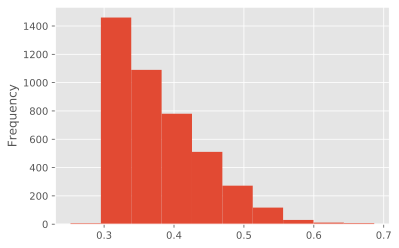

In [91]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df_scored.loc[valid,'all_tweets_proba'].plot.hist()

In [92]:
# df_scored.loc[valid,'domain_proba'].plot.hist()

KeyError: 'domain_proba'

In [ ]:
plt.figure(figsize=[5,15]);
ddd = pd.DataFrame(
    [df_scored.loc[valid & df_scored['after'],'manifestolabel'].value_counts(normalize=True), 
     df_scored.loc[valid & df_scored['before'],'manifestolabel'].value_counts(normalize=True)],
    index=['after','before']).T

ddd[abs(ddd['after'] / ddd['before'] - 1) > .1].plot.barh()

plt.ylim([-1,15.5])
plt.title('Manifestolabels')
plt.xlabel('# Predictions')
plt.tight_layout()
plt.savefig('manifestolabels_before_after.pdf')

<Figure size 360x1080 with 0 Axes>

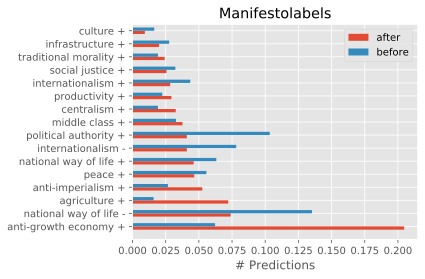

In [71]:
plt.figure(figsize=[5,15])

ddd = pd.DataFrame(
    [df_scored.loc[valid & df_scored['after'],'manifestolabel_keywords'].value_counts(normalize=True), 
     df_scored.loc[valid & df_scored['before'],'manifestolabel_keywords'].value_counts(normalize=True)],
    index=['after','before']).T

ddd[abs(ddd['after'] / ddd['before'] - 1) > .1].plot.barh()


plt.ylim([-1,15.5])
plt.title('Manifestolabels')
plt.xlabel('# Predictions')
plt.tight_layout()
plt.savefig('manifestolabels_before_after_keywords.pdf')

In [72]:
ddd = pd.DataFrame(
    [df_scored.loc[valid & df_scored['after'],'domain'].value_counts(normalize=True), 
     df_scored.loc[valid & df_scored['before'],'domain'].value_counts(normalize=True)],
    index=['after','before']).T

ddd[abs(ddd['after'] / ddd['before'] - 1) > .01].plot.barh()



plt.title('Political Domains')
plt.xlabel('# Predictions')
plt.tight_layout()
plt.savefig('domains_before_after.pdf')

KeyError: 'domain'

In [73]:
pd.DataFrame(
    [df_scored.loc[valid & df_scored['after'],'rightleft'].value_counts(normalize=True), 
     df_scored.loc[valid & df_scored['before'],'rightleft'].value_counts(normalize=True)],
    index=['before','after']).T.plot.bar()


KeyError: 'rightleft'

In [74]:
from classifier import get_manifesto_data
df = get_manifesto_data()
df

Loading manifesto/manifesto-Germany.csv


,text,manifestocodes,domain,rightleft,manifestolabel
0,Es ist Zeit für einen Wechsel,0,None,None,undefined
1,"Die Bundesrepublik braucht eine neue, eine soziale und ökologische Politik",303,Political System,None,gov-admin efficiency +
2,Die Herausforderungen eines neuen Jahrhunderts sind nicht mit den Konzepten von gestern und vorgestern zu bewältigen,303,Political System,None,gov-admin efficiency +
3,Politik kann nicht alle Probleme lösen,0,None,None,undefined
4,Aber Politik muß ihren Teil zur Lösung der Probleme beitragen,0,None,None,undefined
...,...,...,...,...,...
48471,Deutschland braucht qualifizierte und integrationswillige Zuwanderung.,608,Fabric of Society,None,multiculturalism -
48472,• Wir fordern ein Einwanderungsgesetz nach kanadischem Vorbild.,607,Fabric of Society,None,multiculturalism +
48473,Eine ungeordnete Zuwanderung in unsere Sozialsysteme muss unbedingt unterbunden werden.,601,Fabric of Society,right,national way of life +
48474,• Ernsthaft politisch Verfolgte müssen in Deutschland Asyl finden können.,201,Freedom and Democracy,right,freedom/human rights +


In [75]:
from classifier import get_manifesto_data
df = get_manifesto_data()
df['manifestolabel'] = df['manifestocodes'].astype('str') + " " + df['manifestolabel']
# df[['text','manifestolabel']]
df[['text','manifestolabel']].to_json('manifestodata.json')

Loading manifesto/manifesto-Germany.csv


In [93]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

In [97]:
# Setting variables to be used below
maxTweets = 10

# Creating list to append tweet data to
tweets_list2 = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('demokratie OR corona lang:de since:2020-06-01 until:2020-07-31').get_items()):
    if i>maxTweets:
        break
    tweets_list2.append(tweet.__dict__)

In [99]:
pd.DataFrame(tweets_list2)

,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers
0,https://twitter.com/StaChelRocHeN99/status/1288987701618892801,2020-07-30 23:59:50+00:00,@dunjahayali @_Nicl *Drohnen. Ich wünsche mir Wahrheiten. „Freunde“ muss man kritisieren können. Nur sind das noch Freunde? Wenn ich Trump und seine Agenda sehe nein. Die Kriege sind vor allem nicht etwa entstanden um Demokratie und Menschenrechte zu fördern. Es geht um Interessen.,@dunjahayali @_Nicl *Drohnen. Ich wünsche mir Wahrheiten. „Freunde“ muss man kritisieren können. Nur sind das noch Freunde? Wenn ich Trump und seine Agenda sehe nein. Die Kriege sind vor allem nicht etwa entstanden um Demokratie und Menschenrechte zu fördern. Es geht um Interessen.,1288987701618892801,https://twitter.com/StaChelRocHeN99,[],[],0,0,...,0,1288940571491479553,de,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",http://twitter.com/download/iphone,Twitter for iPhone,None,None,None,"[https://twitter.com/dunjahayali, https://twitter.com/_Nicl]"
1,https://twitter.com/psycofriend/status/1288987605288312833,2020-07-30 23:59:27+00:00,Wieso gibt man eigentlich den Kassierern im Supermarkt kein Trinkgeld? #systemrelevant #mehralsapplaus #corona,Wieso gibt man eigentlich den Kassierern im Supermarkt kein Trinkgeld? #systemrelevant #mehralsapplaus #corona,1288987605288312833,https://twitter.com/psycofriend,[],[],0,1,...,0,1288987605288312833,de,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",https://mobile.twitter.com,Twitter Web App,None,None,None,None
2,https://twitter.com/Process_de/status/1288987597096865792,2020-07-30 23:59:26+00:00,Corona-bedingte Kurzarbeit sinkt nur langsam https://t.co/6bhXSAU2FD via @Process_de,Corona-bedingte Kurzarbeit sinkt nur langsam process.vogel.de/corona-bedingt… via @Process_de,1288987597096865792,https://twitter.com/Process_de,[https://www.process.vogel.de/corona-bedingte-kurzarbeit-sinkt-nur-langsam-a-952905/],[https://t.co/6bhXSAU2FD],0,0,...,0,1288987597096865792,de,"<a href=""http://twibble.io"" rel=""nofollow"">Twibble.io</a>",http://twibble.io,Twibble.io,None,None,None,[https://twitter.com/Process_de]
3,https://twitter.com/abochnak56/status/1288987571356405761,2020-07-30 23:59:19+00:00,"Masken helfen nicht nur gegen Corona, sondern auch gegen Gesichtserkennung https://t.co/YQn0bE1l65","Masken helfen nicht nur gegen Corona, sondern auch gegen Gesichtserkennung 1e9.community/t/masken-helfe…",1288987571356405761,https://twitter.com/abochnak56,[https://1e9.community/t/masken-helfen-nicht-nur-gegen-corona-sondern-auch-gegen-gesichtserkennung/5054],[https://t.co/YQn0bE1l65],0,0,...,0,1288987571356405761,de,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",https://mobile.twitter.com,Twitter Web App,None,None,None,None
4,https://twitter.com/JuttaProhaska/status/1288987557393571840,2020-07-30 23:59:16+00:00,"@der_monk Zu was genau jetzt, braucht ein Land so eine Bereicherung? Meiner Meinung nach, könnte man getrost darauf verzichten. Clan &amp; Corona.","@der_monk Zu was genau jetzt, braucht ein Land so eine Bereicherung? Meiner Meinung nach, könnte man getrost darauf verzichten. Clan &amp; Corona.",1288987557393571840,https://twitter.com/JuttaProhaska,[],[],0,0,...,0,1288956188487491586,de,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",http://twitter.com/download/android,Twitter for Android,None,None,None,[https://twitter.com/der_monk]
5,https://twitter.com/beren_linkehand/status/1288987388291821573,2020-07-30 23:58:36+00:00,"@DerZEUS4 @blauekastanie Es geht um den Tempus.\n\nDie Aussage ""als hätte es Corona nie gegeben"" impliziert, die Krise sei vorbei.\nKorrekt ist ""als gäbe es Corona nicht"".","@DerZEUS4 @blauekastanie Es geht um den Tempus.\n\nDie Aussage ""als hätte es Corona nie geg

In [119]:
stopwords = [x.strip() for x in open('stopwords.txt').readlines()[7:]]

label='all_tweets'
top_what=20
df_bundestag = get_bundestag_data()
df_manifesto = get_manifesto_data()
df_human = get_human_data()
text = pd.concat([df_bundestag['rede'],df_manifesto['text'],df_human['text']],axis=0)
fn = os.path.join(DATADIR, 'classifier-{}.pickle'.format(label))
clf = pickle.load(open(fn,'rb'))
labels_normalized = StandardScaler().fit_transform(clf.predict_proba(text))
vectorizer = clf.steps[0][1]
data_scaled = StandardScaler(with_mean=False).fit_transform(vectorizer.transform(text))
keywords = {}
for iclass, classname in enumerate(clf.steps[1][1].classes_):
    if classname not in ['undefined', 'ignored']:
        pattern = labels_normalized[:,iclass].T @ data_scaled
        idx2word = {idx: word for word, idx in vectorizer.vocabulary_.items()}
        words = pd.Series([idx2word[idx] for idx in pattern.argsort()[::-1]])
        exclude = words.isin(stopwords) | words.str.contains('\d+')
        keywords[classname] = words[~exclude].dropna()[:top_what].values
df_keywords = pd.DataFrame(keywords)
df_keywords.to_csv('keywords.csv', index=False)

Loading manifesto/manifesto-Germany.csv


In [118]:
df_keywords.iloc[:top_what,:]


,agriculture +,anti-growth economy +,anti-imperialism +,centralism +,constitution +,constitution -,controlled economy +,corporatism +,culture +,decentralism +,...,political corruption -,productivity +,protectionism +,protectionism -,social harmony +,social justice +,traditional morality +,traditional morality -,welfare +,welfare -
0,landwirtschaft,nachhaltige,machtpolitischer,bund,grundgesetz,grundgesetz,mindestlohn,arbeitgebern,kultur,kommunen,...,korruption,wachstum,freihandels,handelshemmnisse,engagement,frauen,familien,lebensgemeinschaften,versorgung,vorsorge
1,landwirte,ökologische,interventionismus,betreuungsstandards,grundgesetzes,kinderrechte,gesetzlichen,sozialpartnerschaft,kunst,gemeinden,...,abgeordnetenbestechung,wirtschaftswachstum,freihandelsabkommen,exportsubventionen,bürgerschaftliches,gerechtigkeit,familie,lebenspartnerschaften,grundsicherung,private
2,bauern,nachhaltigkeit,machtinteressen,ländern,verfassung,gg,flächendeckenden,gewerkschaften,kulturelle,länder,...,nebeneinkünfte,wirtschaftliches,transnationaler,doha,solidarität,teilhabe,eltern,füreinander,pflege,eigenverantwortung
3,agrarpolitik,nachhaltiges,orientierende,bildungsstandards,werteordnung,absätze,vergleichsmiete,tarifautonomie,sport,bund,...,bestechlichkeit,wohlstand,behandelter,abschottung,ehrenamt,einkommen,kinder,gleichgeschlechtliche,rente,altersvorsorge
4,ernährungswirtschaft,nachhaltigen,punktesysteme,kooperationsverbot,forderndes,staatsziel,mindestlohns,sozialpartnern,kulturpolitik,kommunalen,...,abgeordneten,beschäftigung,dogmen,anbaugebieten,zusammenhalt,männern,vereinbarkeit,paare,leistungen,betriebliche
5,landwirtschaftlichen,ökologischen,selektiven,abschlussbezogene,wertegerüst,gleichheitsrechte,ortsüblichen,tarifparteien,künstlerinnen,ort,...,rechtsverhältnisse,aufbau,wto,märkte,ehrenamtliche,männer,beruf,cannabis,rentenversicherung,rentenversicherung
6,forstwirtschaft,ökologisch,zuwider,bundesweit,gesellschaftsbild,verankern,auftragnehmern,arbeitnehmern,kulturellen,kommunale,...,bestechung,wirtschaftliche,aufgedrängt,protektionismus,gesellschaft,gleiche,kindern,ehen,kindergeld,eigenvorsorge
7,kulturlandschaft,wirtschaften,neokolonialen,schulsystemen,freiheitlichste,geldwertwertstabilität,französischem,arbeitgeberverbänden,künstler,selbstverwaltung,...,abgeordnetengesetz,brachliegenden,aufkommenden,wto,zivilgesellschaft,diskriminierung,christlichen,drogen,hartz,kapitalgedeckte
8,bäuerinnen,wachstum,partnerländer,energiekonzepten,unantastbar,abs,mieterhöhungen,verabredeten,kulturförderung,städte,...,verstrickte,voraussetzung,welthandelsorganisation,hauptexportprodukten,engagements,herkunft,kirchen,eingetragene,iv,alterssicherung
9,landwirtschaftliche,entwicklung,kontingente,verständigen,zusammenlebens,kooperationsverbots,vorschreibt,tarifpartnern,öffentlich,ländern,...,spenden,dynamik,unbeschränkte,handelsbarrieren,ehrenamtliches,gleichstellung,erziehung,patchwork,pflegeversicherung,kapitaldeckung


In [116]:
words[~exclude].dropna()[:top_what]


0     vorsorge          
1     private           
2     eigenverantwortung
3     altersvorsorge    
4     betriebliche      
5     rentenversicherung
6     eigenvorsorge     
7     kapitalgedeckte   
8     alterssicherung   
9     kapitaldeckung    
10    rente             
11    kapitalgedeckten  
12    gesetzlichen      
13    altersversorgung  
14    betriebsrenten    
15    privaten          
16    arbeitslosengeld  
17    betrieblichen     
18    gesetzliche       
19    alter             
dtype: object